In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [32]:
# Read co-occurence data
df1 = pd.read_csv("persons_organizations_co-occurences(1).csv", usecols=['V1Persons', 'V1Organizations']).dropna()
df2 = pd.read_csv("persons_organizations_co-occurences(2).csv", usecols=['V1Persons', 'V1Organizations']).dropna()
df3 = pd.concat([df1, df2])

# Read occurence data
per_occ = pd.read_csv("persons_occurences.csv", nrows=25)
org_occ = pd.read_csv("organizations_occurences.csv", nrows=25)

# Create a dictionnary that maps an actor to its occurence
per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace("-", "_"))
per_occ_dict = per_occ.set_index('Actor').to_dict()['Count']
top_persons = list(per_occ_dict.keys())
org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace("-", "_"))
org_occ_dict = org_occ.set_index('Actor').to_dict()['Count']
top_organizations = list(org_occ_dict.keys())
actor_occ_dict = dict(per_occ_dict, **org_occ_dict)

# Filter and clean dataframe
df = df3.copy()
df['V1Persons'] = df["V1Persons"].str.replace(" ","_")
df['V1Persons'] = df["V1Persons"].str.replace("-","_")
df['V1Organizations'] = df["V1Organizations"].str.replace(" ","_")
df['V1Organizations'] = df["V1Organizations"].str.replace("-","_")
df['V1Persons'] = df["V1Persons"].str.replace(";"," ")
df['V1Persons'] = df['V1Persons'].apply(lambda x: ' '.join([y for y in x.split() if y in top_persons]))
df['V1Organizations'] = df["V1Organizations"].str.replace(";"," ")
df['V1Organizations'] = df['V1Organizations'].apply(lambda x: ' '.join([y for y in x.split() if y in top_organizations]))
df["actors"] = df["V1Persons"].map(str) + ' ' + df["V1Organizations"]
df = df.drop(columns=['V1Persons', 'V1Organizations'])

df['totalwords'] = df['actors'].str.split().str.len()
df = df.loc[df['totalwords'] >= 2]
df = df.drop(columns=['totalwords'])

df.to_csv('global_actors_co-occurences_25.csv', index=False)

In [39]:
# Read co-occurence data
df1 = pd.read_csv("persons_organizations_co-occurences(1).csv", usecols=['V1Persons', 'V1Organizations']).dropna()
df2 = pd.read_csv("persons_organizations_co-occurences(2).csv", usecols=['V1Persons', 'V1Organizations']).dropna()
df3 = pd.concat([df1, df2])

# Read occurence data
per_occ = pd.read_csv("persons_occurences.csv", nrows=50)
org_occ = pd.read_csv("organizations_occurences.csv", nrows=50)

# Create a dictionnary that maps an actor to its occurence
per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace("-", "_"))
per_occ_dict = per_occ.set_index('Actor').to_dict()['Count']
top_persons = list(per_occ_dict.keys())
org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace("-", "_"))
org_occ_dict = org_occ.set_index('Actor').to_dict()['Count']
top_organizations = list(org_occ_dict.keys())
actor_occ_dict = dict(per_occ_dict, **org_occ_dict)

# Filter and clean dataframe
df = df3.copy()
df['V1Persons'] = df["V1Persons"].str.replace(" ","_")
df['V1Persons'] = df["V1Persons"].str.replace("-","_")
df['V1Organizations'] = df["V1Organizations"].str.replace(" ","_")
df['V1Organizations'] = df["V1Organizations"].str.replace("-","_")
df['V1Persons'] = df["V1Persons"].str.replace(";"," ")
df['V1Persons'] = df['V1Persons'].apply(lambda x: ' '.join([y for y in x.split() if y in top_persons]))
df['V1Organizations'] = df["V1Organizations"].str.replace(";"," ")
df['V1Organizations'] = df['V1Organizations'].apply(lambda x: ' '.join([y for y in x.split() if y in top_organizations]))
df["actors"] = df["V1Persons"].map(str) + ' ' + df["V1Organizations"]
df = df.drop(columns=['V1Persons', 'V1Organizations'])

df['totalwords'] = df['actors'].str.split().str.len()
df = df.loc[df['totalwords'] >= 2]
df = df.drop(columns=['totalwords'])

df.to_csv('global_actors_co-occurences_50.csv', index=False)

In [44]:
def plot_occ_graph(file, min_actor_rank, edge_size, node_weight_exp, spacing, figsize):
    df = pd.read_csv(file)
    
    # Read occurence data
    per_occ = pd.read_csv("persons_occurences.csv", nrows=min_actor_rank)
    org_occ = pd.read_csv("organizations_occurences.csv", nrows=min_actor_rank)
    
    # Create a dictionnary that maps an actor to its occurence
    per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
    per_occ['Actor'] = per_occ['Actor'].apply(lambda x: x.replace("-", "_"))
    per_occ_dict = per_occ.set_index('Actor').to_dict()['Count']
    top_persons = list(per_occ_dict.keys())
    org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace(" ", "_"))
    org_occ['Actor'] = org_occ['Actor'].apply(lambda x: x.replace("-", "_"))
    org_occ_dict = org_occ.set_index('Actor').to_dict()['Count']
    top_organizations = list(org_occ_dict.keys())
    actor_occ_dict = dict(per_occ_dict, **org_occ_dict)
    
    # Create the co-occurence matrix
    docs = df.values.flatten().tolist()
    count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
    X = count_model.fit_transform(docs)
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    Xc.setdiag(0)
    
    # Capitalize and remove underscore in actor names
    nodes = count_model.get_feature_names()
    nodes = [x.replace("_", " ") for x in nodes]
    nodes = [' '.join([x.capitalize() for x in y.split()]) for y in nodes]

    # Create the weighted edge list
    Knz = Xc.nonzero()
    sparserows = Knz[0]
    sparsecols = Knz[1]
    edge_list = [x for x in list(zip(list(sparserows), list(sparsecols))) if x[0] <= x[1]]
    weights = [Xc[x[0], x[1]]*0.001*edge_size for x in edge_list]
    weighted_edge_list = [(x[0][0], x[0][1], x[1]) for x in list(zip(edge_list, weights))]
    weighted_edge_list = [(nodes[x[0]], nodes[x[1]], x[2]) for x in weighted_edge_list]

    # Plot the graph
    plt.subplots(figsize=(figsize,figsize))
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edge_list)
    vertices = [x for x in G.nodes()]
    vertices = [x.replace(" ", "_") for x in vertices]
    vertices = [x.lower() for x in vertices]
    node_col = ['#ff8d00' if x in top_organizations else '#00c900' for x in vertices]
    node_sizes = [actor_occ_dict.get(x)**node_weight_exp for x in vertices]
    pos = nx.spring_layout(G, k=spacing/(G.order()**0.5))
    nx.draw(G, pos, with_labels=True, font_size = 12, font_weight = 'bold',
            width=[G[u][v]['weight'] for u,v in G.edges()], node_size=node_sizes, font_color='k', node_color=node_col)
    plt.axis('off')
    plt.show()

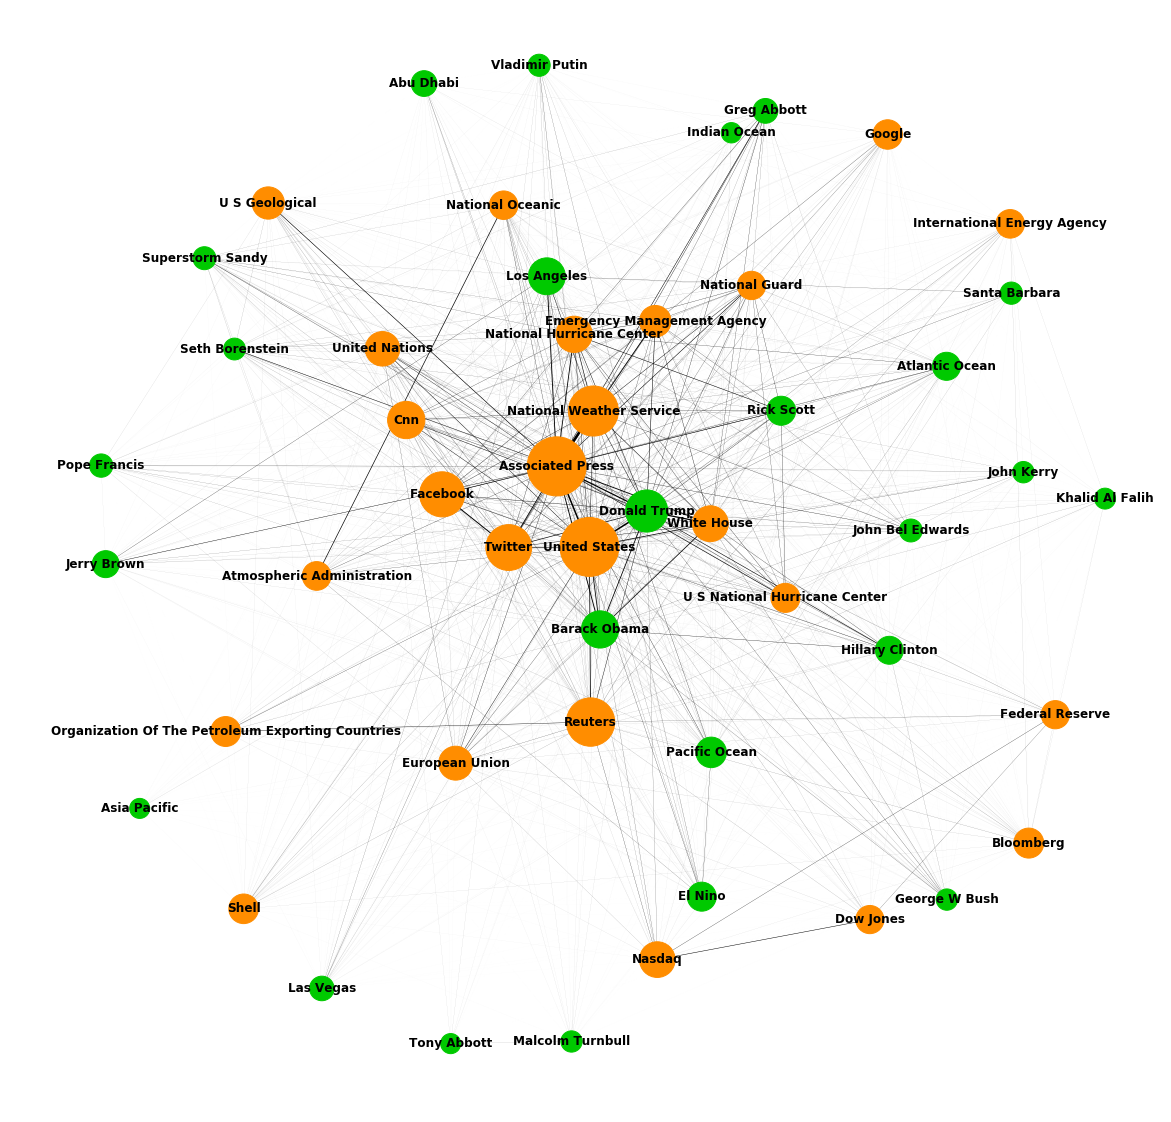

In [45]:
plot_occ_graph('global_actors_co-occurences_25.zip', 25, 0.01, 0.6, 7, 20)

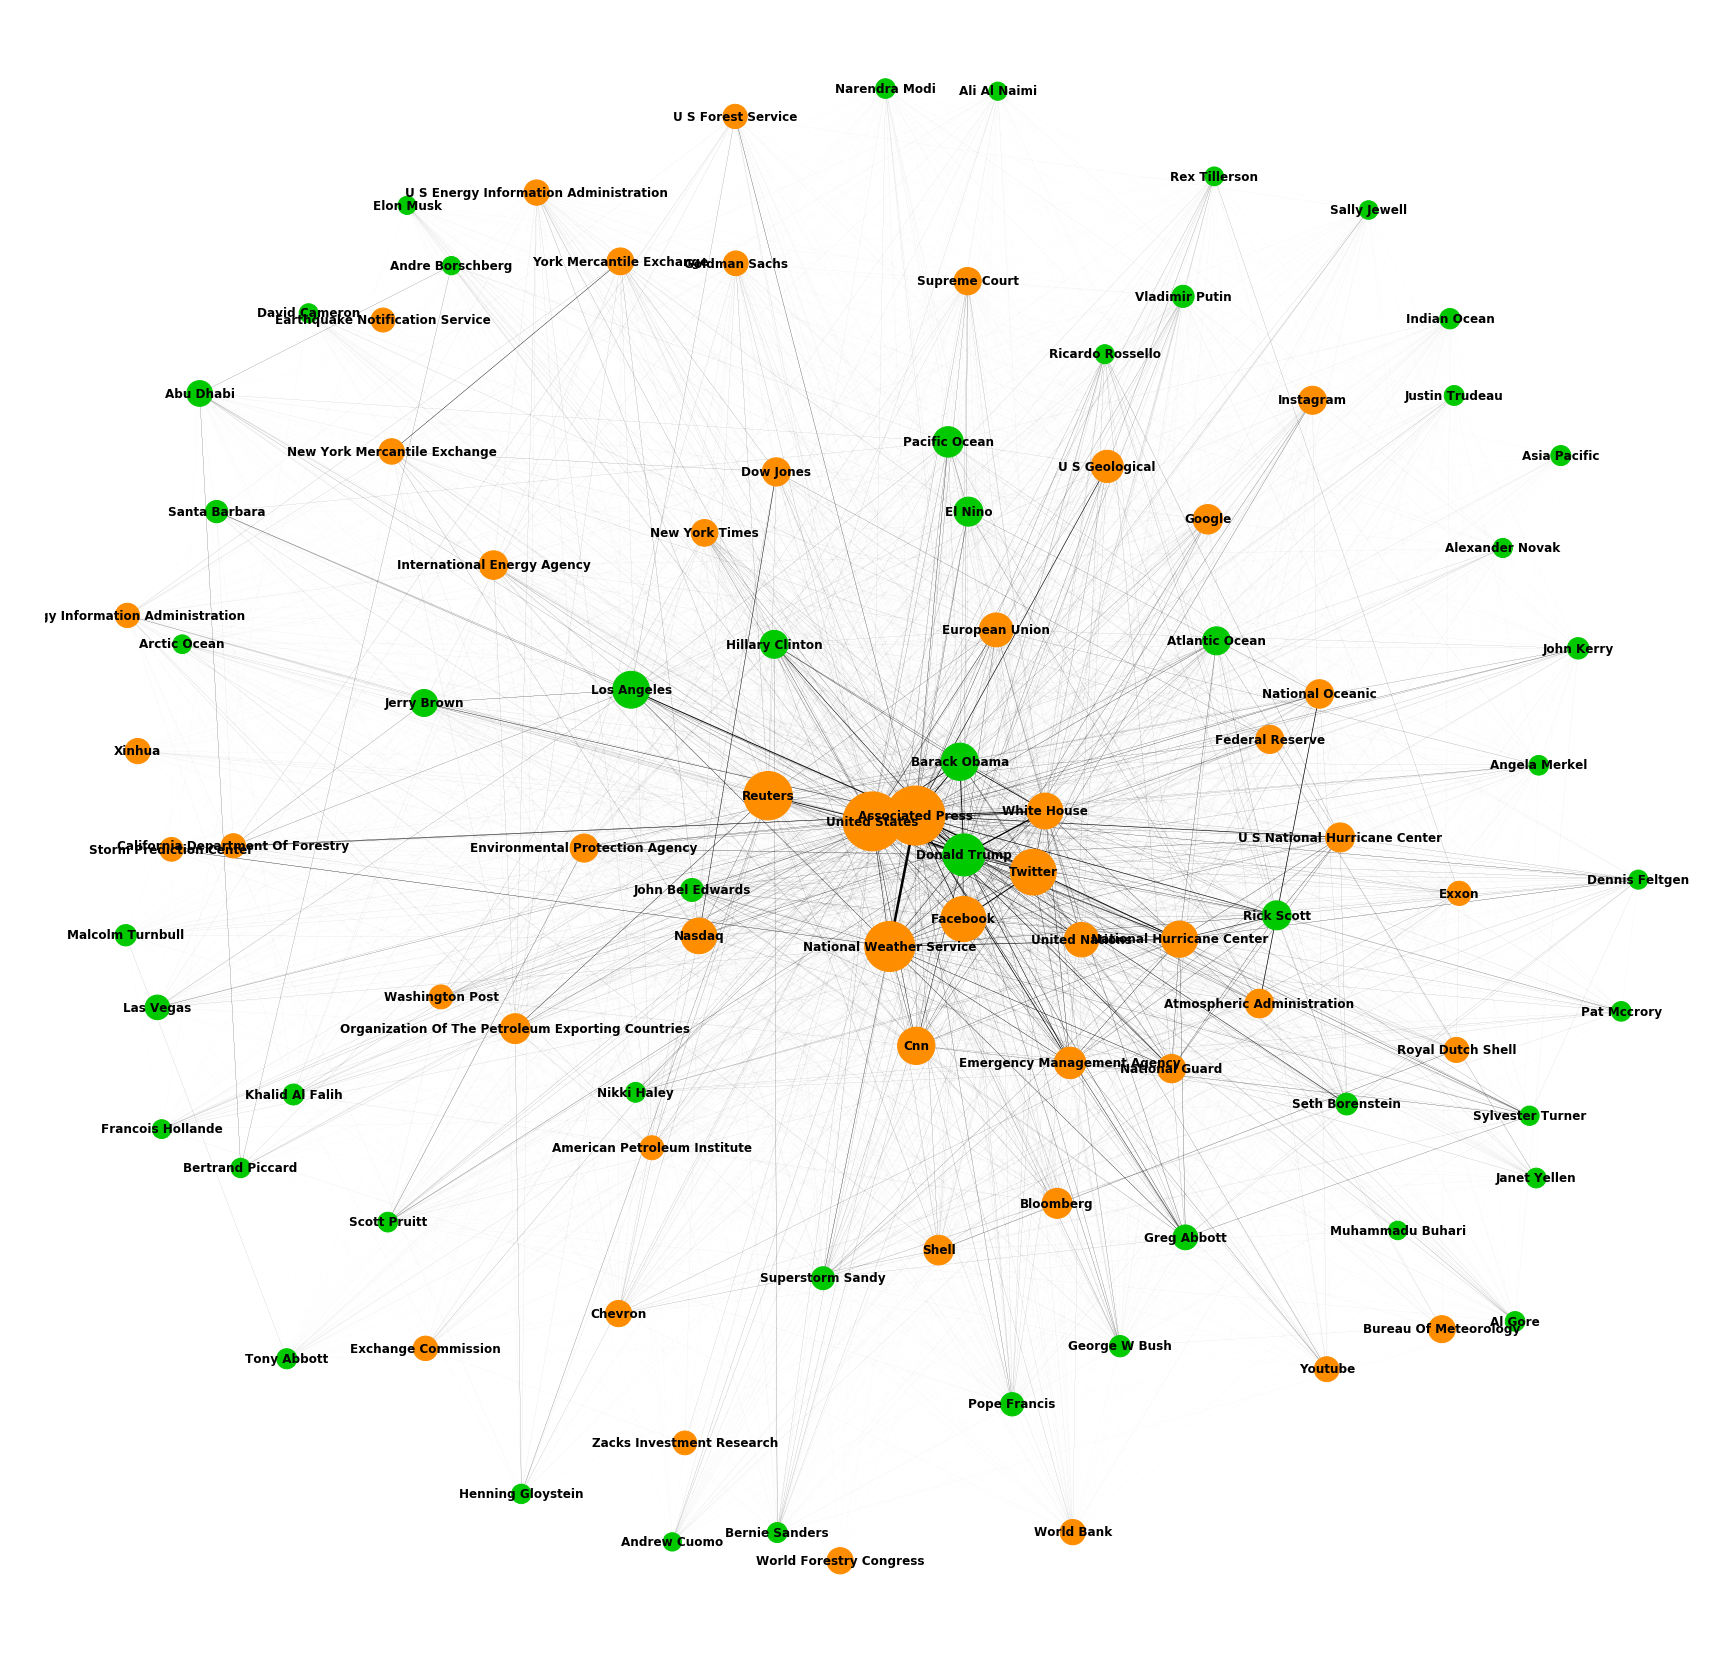

In [46]:
plot_occ_graph('global_actors_co-occurences_50.zip', 50, 0.01, 0.6, 7, 30)